In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import silhouette_score
from nltk.corpus import stopwords
import nltk
import gensim
from gensim import corpora
import spacy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import warnings

In [2]:
# Download NLTK stopwords
nltk.download('stopwords')

# Suppress warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Load the data
data = pd.read_csv("data/Tweets.csv")
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


# Exploring the data

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

# **Fields and Data Types 🗒️**  
Dataset containing tweets related to airlines, labeled with sentiment analysis and additional metadata. The data consists of user tweets mentioning airlines, including sentiment classification, potential negative reasons, and metadata such as location and retweets.  

## **Data Dictionary**  

| **Parameter**                    | **Description**                                                                                                                                      |
|----------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------|
| `tweet_id`                      | Unique identifier assigned to each tweet.                                                                                                      |
| `airline_sentiment`             | Sentiment classification of the tweet (`positive`, `neutral`, `negative`).                                                                    |
| `airline_sentiment_confidence`  | Confidence score for the sentiment classification, indicating model certainty.                                                                |
| `negativereason`                | Specific reason for a negative sentiment tweet (e.g., `Late Flight`, `Customer Service Issue`). Only present for negative tweets.            |
| `negativereason_confidence`     | Confidence score for the negative reason classification.                                                                                       |
| `airline`                       | Name of the airline mentioned in the tweet.                                                                                                   |
| `airline_sentiment_gold`        | Expert-labeled sentiment (if available). Only a small subset of tweets have this label.                                                      |
| `name`                          | Name of the user who posted the tweet.                                                                                                       |
| `negativereason_gold`           | Expert-labeled negative reason classification (if available). Only a small subset of tweets have this label.                                |
| `retweet_count`                 | Number of times the tweet was retweeted.                                                                                                     |
| `text`                          | Full text content of the tweet.                                                                                                              |
| `tweet_coord`                   | Geographic coordinates of the tweet, if available.                                                                                          |
| `tweet_created`                 | Timestamp of when the tweet was posted.                                                                                                     |
| `tweet_location`                | User-provided location in their Twitter profile.                                                                                            |
| `user_timezone`                 | Timezone of the user, if available.                                                                                                        |

In [5]:
# Display the dimensions of the dataset
data.shape

(14640, 15)

In [6]:
# Display descriptive statistics of the dataset
data.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [7]:
# Display column names of the dataset
data.columns.values

array(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'], dtype=object)

In [8]:
# Count the ocurrences of each Airline in the dataset
data.airline.value_counts()

airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: count, dtype: int64

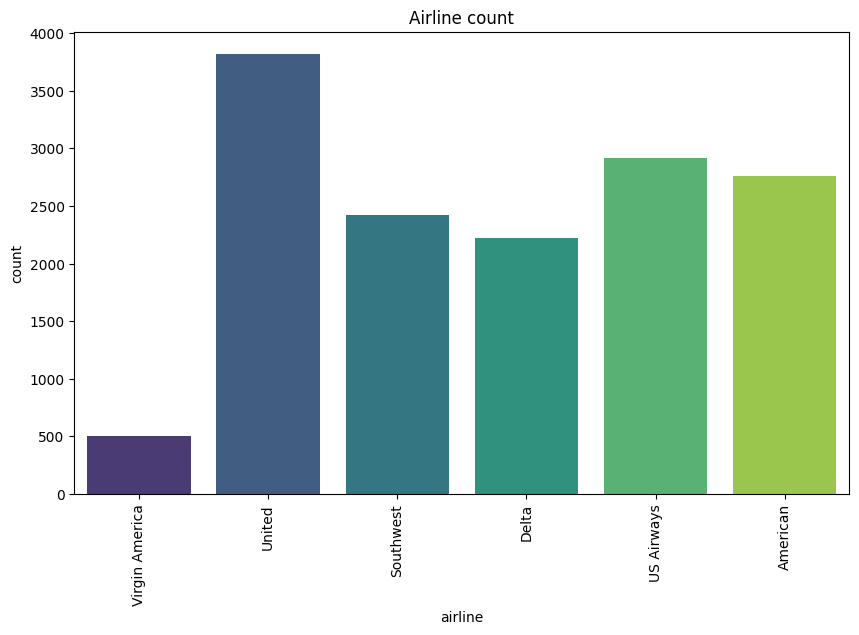

In [9]:
plt.figure(figsize=(10,6))
sns.countplot(x='airline',data=data, palette='viridis')
plt.xticks(rotation=90)
plt.title("Airline count")
plt.show()

# Now i going to checking the number of unique values in each column

In [10]:
dict = {}
for i in list(data.columns):
    dict[i] = data[i].value_counts().shape[0]
pd.DataFrame(dict, index=['unique count']).transpose()

,unique count
tweet_id,14485
airline_sentiment,3
airline_sentiment_confidence,1023
negativereason,10
negativereason_confidence,1410
airline,6
airline_sentiment_gold,3
name,7701
negativereason_gold,13
retweet_count,18


# Missing values

In [11]:
data.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [12]:
# Calculate the threshold for dropping columns
threshold = len(data) * 0.8

# Drop columns with too many missing values
data_cleaned = data.dropna(thresh=threshold, axis=1)

# Impute missing values for categorical columns
categorical_cols = data_cleaned.select_dtypes(include=['object']).columns
for col in categorical_cols:
    # Check if the column has missing values
    if data_cleaned[col].isnull().sum() > 0:
        # Calculate the mode
        mode_value = data_cleaned[col].mode()[0]
        # Fill missing values with the mode
        data_cleaned[col].fillna(mode_value, inplace=True)

# Impute missing values for numerical columns
numerical_cols = data_cleaned.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    # Check if the column has missing values
    if data_cleaned[col].isnull().sum() > 0:
        # Calculate the median
        median_value = data_cleaned[col].median()
        # Fill missing values with the median
        data_cleaned[col].fillna(median_value, inplace=True)

In [13]:
print("\nMissing Values After Handling:")
print(data_cleaned.isnull().sum())


Missing Values After Handling:
tweet_id                        0
airline_sentiment               0
airline_sentiment_confidence    0
airline                         0
name                            0
retweet_count                   0
text                            0
tweet_created                   0
dtype: int64


# EDA (Exploratory Data Analysis)

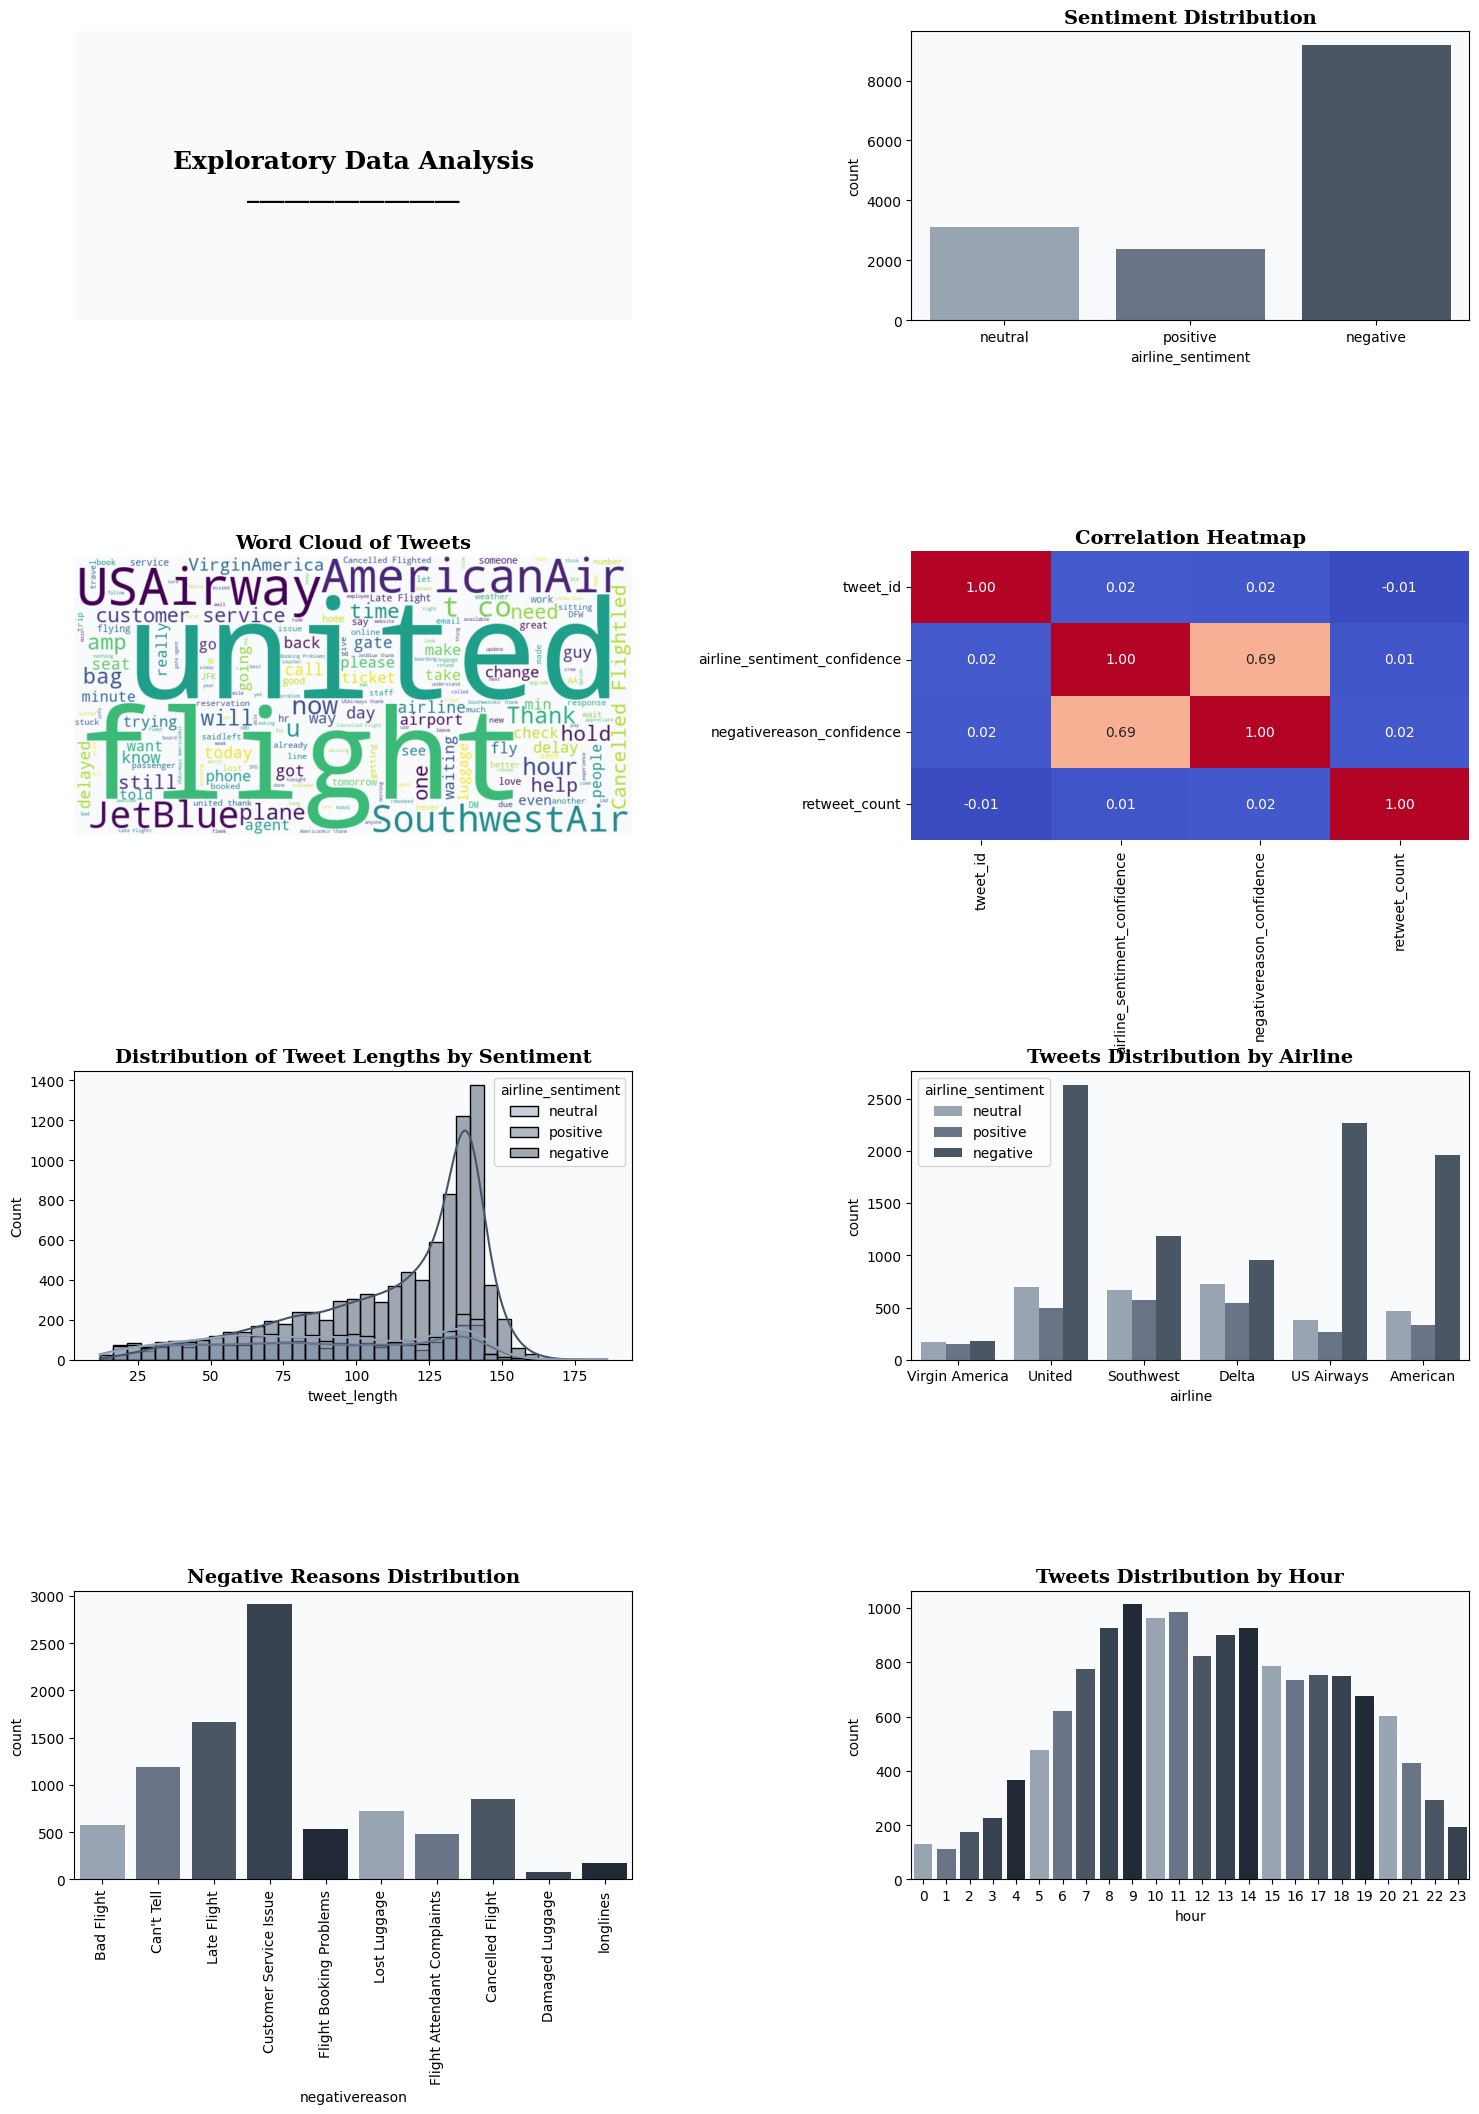

In [15]:
# General plot settings
background_color = "#f8fafc"
color_palette = ["#94a3b8", "#64748b", "#475569", "#334155", "#1e293b"]

# Adjust figure size and layout
fig = plt.figure(figsize=(18, 24))
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.5, hspace=0.8)

# Create axes for subplots
axes = [fig.add_subplot(gs[i, j]) for i in range(4) for j in range(2)]
for ax in axes:
    ax.set_facecolor(background_color)

# Title for the overall analysis
axes[0].spines["bottom"].set_visible(False)
axes[0].spines["left"].set_visible(False)
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)
axes[0].tick_params(left=False, bottom=False)
axes[0].set_xticklabels([])
axes[0].set_yticklabels([])
axes[0].text(0.5, 0.5,
             'Exploratory Data Analysis\n_________________',
             horizontalalignment='center',
             verticalalignment='center',
             fontsize=18, fontweight='bold',
             fontfamily='serif',
             color="#000000")

# Count plot for sentiment distribution (if available)
if 'airline_sentiment' in data.columns:
    sns.countplot(ax=axes[1], data=data, x='airline_sentiment', palette=color_palette)
    axes[1].set_title('Sentiment Distribution', fontsize=14, fontweight='bold', fontfamily="serif", color="#000000")

# Word cloud for most frequent words
from wordcloud import WordCloud
text = " ".join(data['text'])
wordcloud = WordCloud(background_color=background_color, width=800, height=400).generate(text)
axes[2].imshow(wordcloud, interpolation='bilinear')
axes[2].axis('off')
axes[2].set_title('Word Cloud of Tweets', fontsize=14, fontweight='bold', fontfamily="serif", color="#000000")

# Correlation heatmap for numeric data
numeric_data = data.select_dtypes(include=[np.number])
corr_matrix = numeric_data.corr()
sns.heatmap(corr_matrix, ax=axes[3], annot=True, fmt='.2f', cmap='coolwarm', cbar=False)
axes[3].set_title('Correlation Heatmap', fontsize=14, fontweight='bold', fontfamily="serif", color="#000000")

# Distribution of tweet lengths
data['tweet_length'] = data['text'].apply(len)
sns.histplot(ax=axes[4], data=data, x='tweet_length', hue='airline_sentiment', kde=True, palette=color_palette)
axes[4].set_title('Distribution of Tweet Lengths by Sentiment', fontsize=14, fontweight='bold', fontfamily="serif", color="#000000")

# Distribution of tweets by airline
if 'airline' in data.columns:
    sns.countplot(ax=axes[5], data=data, x='airline', hue='airline_sentiment', palette=color_palette)
    axes[5].set_title('Tweets Distribution by Airline', fontsize=14, fontweight='bold', fontfamily="serif", color="#000000")

# Distribution of negative reasons
if 'negativereason' in data.columns:
    sns.countplot(ax=axes[6], data=data, x='negativereason', palette=color_palette)
    axes[6].set_title('Negative Reasons Distribution', fontsize=14, fontweight='bold', fontfamily="serif", color="#000000")
    axes[6].tick_params(axis='x', rotation=90)

# Distribution of tweets over time
if 'tweet_created' in data.columns:
    data['tweet_created'] = pd.to_datetime(data['tweet_created'])
    data['hour'] = data['tweet_created'].dt.hour
    sns.countplot(ax=axes[7], data=data, x='hour', palette=color_palette)
    axes[7].set_title('Tweets Distribution by Hour', fontsize=14, fontweight='bold', fontfamily="serif", color="#000000")

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
# Preprocess the text by removing stopwords, punctuation, and lemmatizing.
def preprocess_text(text):
    # Load SpaCy's English model
    nlp = spacy.load('en_core_web_sm')

    # Tokenize and lemmatize the text
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha]

    return " ".join(tokens)

# Apply preprocessing to the text column
data['processed_text'] = data['text'].apply(preprocess_text)

In [ ]:
# Vectorize the text using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(data['processed_text'])

# Clustering for Sentiment Analysis and perform K-Means Clustering for sentiment grouping


In [ ]:
# Perform K-Means Clustering for sentiment grouping:
# assuming 3 clusters: positive, negative, neutral
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
data['cluster'] = kmeans.fit_predict(tfidf_matrix)

# Evaluate clustering using silhouette score
silhouette_avg = silhouette_score(tfidf_matrix, data['cluster'])
print(f"Silhouette Score: {silhouette_avg:.2f}")

# Analyze the clusters
cluster_counts = data['cluster'].value_counts()
print("Cluster Distribution:")
print(cluster_counts)

# Map clusters to sentiment labels (assuming cluster 0: negative, 1: neutral, 2: positive)
cluster_to_sentiment = {0: 'negative', 1: 'neutral', 2: 'positive'}
data['predicted_sentiment'] = data['cluster'].map(cluster_to_sentiment)

# Display sample results
print(data[['text', 'predicted_sentiment']].head(10))

# Topic Modeling using Latent Dirichlet Allocation (LDA)

In [ ]:
# Perform LDA for topic modeling

# Assuming 3 topics
num_topics = 3
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(tfidf_matrix)

# Display the top words for each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Get the feature names from the TF-IDF vectorizer
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
display_topics(lda, tfidf_feature_names, no_top_words=10)

# Model Evaluation Function

In [ ]:
# Evaluate clustering models using silhouette score.
def evaluate_clustering(model, X, labels):
    silhouette_avg = silhouette_score(X, labels)
    print(f"Silhouette Score: {silhouette_avg:.2f}")

# Evaluate K-Means clustering
evaluate_clustering(kmeans, tfidf_matrix, data['cluster'])

# Save the results to a new CSV file
data.to_csv('sentiment_analysis_results.csv', index=False)